In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.nlp import *
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from torchtext import vocab, data, datasets
import pandas as pd

In [2]:
sl=1000
vocab_size=200000

In [3]:
#PATH='/data2/datasets/part1/arxiv/arxiv.csv'
PATH='data/arxiv-twitterbot/brundage_bot.csv'

df = pd.read_csv(PATH)
df.head()

,link,time,favorites,rts,authors,category,published,summary,title,tweeted
0,arxiv.org/abs/1611.10003,NaN,NaN,NaN,"[Tom A. F. Anderson, C. -H. Ruan]",q-bio.NC,2016-11-30 05:17:11,In summary of the research findings presented ...,Vocabulary and the Brain: Evidence from Neuroi...,0
1,arxiv.org/abs/1611.10007,NaN,NaN,NaN,"[M. Amin Rahimian, Amir G. Aghdam]",cs.SY,2016-11-30 05:37:11,"In this paper, structural controllability of a...",Structural Controllability of Multi-Agent Netw...,0
2,arxiv.org/abs/1611.10010,NaN,NaN,NaN,"[Debidatta Dwibedi, Tomasz Malisiewicz, Vijay ...",cs.CV,2016-11-30 06:00:47,We present a Deep Cuboid Detector which takes ...,Deep Cuboid Detection: Beyond 2D Bounding Boxes,0
3,arxiv.org/abs/1611.10012,2016-12-01 01:46:12,11.0,2.0,"[Jonathan Huang, Vivek Rathod, Chen Sun, Mengl...",cs.CV,2016-11-30 06:06:15,"In this paper, we study the trade-off between ...",Speed/accuracy trade-offs for modern convoluti...,1
4,arxiv.org/abs/1611.10014,NaN,NaN,NaN,"[Yoones Hashemi, Amir H. Banihashemi]",cs.IT,2016-11-30 06:12:45,"In this paper, we propose a characterization o...",Characterization and Efficient Exhaustive Sear...,0


In [4]:
df['txt'] = df.category + ' ' + df.title + '\n' + df.summary

In [5]:
print(df.iloc[0].txt)

q-bio.NC Vocabulary and the Brain: Evidence from Neuroimaging Studies
In summary of the research findings presented in this paper, various brain
regions are correlated with vocabulary and vocabulary acquisition. Semantic
associations for vocabulary seem to be located near brain areas that vary
according to the type of vocabulary, e.g. ventral temporal regions important
for words for things that can be seen. Semantic processing is believed to be
strongly associated with the ANG. Phonological ability has been closely related
to the anterior surfaces of the SMG. Pathways through the posterior SMG are
thought to link the anterior SMG and the ANG. In vocabulary tasks,
mediotemporal structures may be related to long-term memory processing, with
left hippocampal and parahippocampal regions related to long-term and working
memory, respectively. Precentral structures are associated with phonological
retrieval. Furthermore, many more regions of the brain are of interest in
vocabulary tasks, part

In [6]:
n=len(df); n

27188

In [7]:
val_idx = get_cv_idxs(n, val_pct=0.1)
((val,trn),(val_y,trn_y)) = split_by_idx(val_idx, df.txt.values, df.tweeted.values)

## Ngram logistic regression

In [8]:
veczr =  CountVectorizer(ngram_range=(1,3), tokenizer=tokenize)
trn_term_doc = veczr.fit_transform(trn) # scipy.sparse.csr.csr_matrix
val_term_doc = veczr.transform(val)
trn_term_doc.shape, trn_term_doc.sum()

((24470, 3773961), 14920806)

In [11]:
y=trn_y
x=trn_term_doc.sign() # Element-wise sign. The sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0.
val_x = val_term_doc.sign()

In [12]:
p = x[np.argwhere(y!=0)[:,0]].sum(0)+1
q = x[np.argwhere(y==0)[:,0]].sum(0)+1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [13]:
pre_preds = val_term_doc @ r.T + b # The @ (at) operator is intended to be used for matrix multiplication. See https://stackoverflow.com/questions/27385633/what-is-the-symbol-for-in-python
preds = pre_preds.T>0
(preds==val_y).mean()

0.8094186902133922

In [14]:
m = LogisticRegression(C=0.1, fit_intercept=False)
m.fit(x, y);

preds = m.predict(val_x)
(preds.T==val_y).mean()

0.8532008830022075

In [15]:
probs = m.predict_proba(val_x)[:,1]

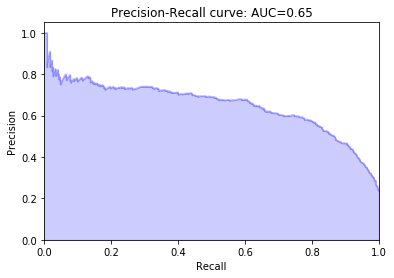

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(val_y, probs)
average_precision = average_precision_score(val_y, probs)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AUC={0:0.2f}'.format(average_precision));

In [17]:
recall[precision>=0.6][0]

0.7486338797814208

In [18]:
df_val = df.iloc[sorted(val_idx)]

In [19]:
incorrect_yes = np.where((preds != val_y) & (val_y == 0))[0]
most_incorrect_yes = np.argsort(-probs[incorrect_yes])
txts = df_val.iloc[incorrect_yes[most_incorrect_yes[:10]]]
txts[["link", "title", "summary"]]

,link,title,summary
7363,arxiv.org/abs/1703.01703,Third-Person Imitation Learning,Reinforcement learning (RL) makes it possible ...
18948,arxiv.org/abs/1707.04615,On the Complexity of Learning Neural Networks,The stunning empirical successes of neural net...
27079,arxiv.org/abs/1710.03804,End-to-End Deep Learning for Steering Autonomo...,Steering a car through traffic is a complex ta...
26327,arxiv.org/abs/1710.00641,Improving speech recognition by revising gated...,Speech recognition is largely taking advantage...
26608,arxiv.org/abs/1710.01916,A self-organizing neural network architecture ...,The visual recognition of transitive actions c...
26262,arxiv.org/abs/1710.00421,Video Generation From Text,Generating videos from text has proven to be a...
24472,arxiv.org/abs/1709.04577,DeepVoting: An Explainable Framework for Seman...,"In this paper, we study the task of detecting ..."
9201,arxiv.org/abs/1703.08595,Low Precision Neural Networks using Subband De...,Large-scale deep neural networks (DNN) have be...
24148,arxiv.org/abs/1709.03423,Ensemble Methods as a Defense to Adversarial P...,Deep learning has become the state of the art ...
26655,arxiv.org/abs/1710.02095,Machine Translation Evaluation with Neural Net...,We present a framework for machine translation...


In [20]:
' '.join(txts.link.values)

'arxiv.org/abs/1703.01703 arxiv.org/abs/1707.04615 arxiv.org/abs/1710.03804 arxiv.org/abs/1710.00641 arxiv.org/abs/1710.01916 arxiv.org/abs/1710.00421 arxiv.org/abs/1709.04577 arxiv.org/abs/1703.08595 arxiv.org/abs/1709.03423 arxiv.org/abs/1710.02095'

In [21]:
incorrect_no = np.where((preds != val_y) & (val_y == 1))[0]
most_incorrect_no = np.argsort(probs[incorrect_no])
txts = df_val.iloc[incorrect_no[most_incorrect_no[:10]]]

In [22]:
txts[["link", "title", "summary"]]

,link,title,summary
5211,arxiv.org/abs/1702.03152,A Variation of Levin Search for All Well-Defin...,"In 1973, L.A. Levin published an algorithm tha..."
5561,arxiv.org/abs/1702.04565,The Accuracy-Privacy Tradeoff of Mobile Crowds...,Mobile crowdsensing has emerged as an efficien...
17196,arxiv.org/abs/1706.08431,Bounds on the Satisfiability Threshold for Pow...,Propositional satisfiability (SAT) is one of t...
14475,arxiv.org/abs/1705.09328,Operation Frames and Clubs in Kidney Exchange,A kidney exchange is a centrally-administered ...
17996,arxiv.org/abs/1707.01123,LittleDarwin: a Feature-Rich and Extensible Mu...,Mutation testing is a well-studied method for ...
16551,arxiv.org/abs/1706.05858,Feature analysis of multidisciplinary scientif...,The features of collaboration behaviors are of...
17956,arxiv.org/abs/1707.00936,Window-of-interest based Multi-objective Evolu...,The set-based concept approach has been sugges...
6309,arxiv.org/abs/1702.07195,First Experiences Optimizing Smith-Waterman on...,The well-known Smith-Waterman (SW) algorithm i...
23216,arxiv.org/abs/1709.00092,RANK: Large-Scale Inference with Graphical Non...,Power and reproducibility are key to enabling ...
3710,arxiv.org/abs/1701.06246,Neural network representation of tensor networ...,We study the representational power of a Boltz...


In [23]:
' '.join(txts.link.values)

'arxiv.org/abs/1702.03152 arxiv.org/abs/1702.04565 arxiv.org/abs/1706.08431 arxiv.org/abs/1705.09328 arxiv.org/abs/1707.01123 arxiv.org/abs/1706.05858 arxiv.org/abs/1707.00936 arxiv.org/abs/1702.07195 arxiv.org/abs/1709.00092 arxiv.org/abs/1701.06246'

In [24]:
to_review = np.where((preds > 0.8) & (val_y == 0))[0]
to_review_idx = np.argsort(-probs[to_review])
txts = df_val.iloc[to_review[to_review_idx]]

In [25]:
txt_html = ('<li><a href="http://' + txts.link + '">' + txts.title.str.replace('\n',' ') + '</a>: ' 
    + txts.summary.str.replace('\n',' ') + '</li>').values

In [26]:
full_html = (f"""<!DOCTYPE html>
<html>
<head><title>Brundage Bot Backfill</title></head>
<body>
<ul>
{os.linesep.join(txt_html)}
</ul>
</body>
</html>""")

## Learner

In [27]:
veczr = CountVectorizer(ngram_range=(1,3), tokenizer=tokenize, max_features=vocab_size)

trn_term_doc = veczr.fit_transform(trn)
val_term_doc = veczr.transform(val)

In [28]:
trn_term_doc.shape, trn_term_doc.sum()

((24470, 200000), 10263165)

In [29]:
md = TextClassifierData.from_bow(trn_term_doc, trn_y, val_term_doc, val_y, sl)

In [30]:
learner = md.dotprod_nb_learner(r_adj=20)

In [ ]:
# http://forums.fast.ai/t/howto-installation-on-windows/10439/87

# You have to change code in fastai/metrics.py

# Before
#def accuracy_multi(preds, targs, thresh):
#    return ((preds>thresh)==targs).float().mean()

# After
#def accuracy_multi(preds, targs, thresh):
#    return ((preds>thresh).float()==targs).float().mean()

In [31]:
learner.fit(0.02, 4, wds=1e-6, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   <lambda>                    
    0      0.140635   0.176054   0.85063   
    1      0.112717   0.171411   0.852859                    
    2      0.097802   0.170575   0.849225                     
    3      0.079685   0.170403   0.847723                     



[0.17040315, 0.8477228685866954]

In [32]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def prec_at_6(preds,targs):
    precision, recall, _ = precision_recall_curve(targs[:,1], preds[:,1])
    return recall[precision>=0.6][0]

In [33]:
prec_at_6(*learner.predict_with_targs())

0.6994535519125683